In [13]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [14]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

In [15]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=10)

![title](img/theory.jpeg)

In [16]:
def NewtonianPotential(r, a=1):
    return 1.0 / (r + a)


def QuarterPotential(r):
    return 15 / 16 * (1 - r ** 2)**2


def TrianglePotential(r):
    return 1 - np.abs(r)


def GaussianPotential(r):
    return (2 * np.pi) ** (-1 / 2) * np.exp(- 1 / 2 * r ** 2)


def EpanechnicovPotential(r):
    return 3 / 4 * (1 - r ** 2)

In [17]:
from sklearn import metrics


class PotentialClassifier:
    def __init__(self, train_x: np.array, train_y: np.array, kernel, window_width, epoch_number: int):
        self.classes = np.unique(train_y)
        self.train_x = train_x
        self.train_y = train_y
        self.gammas = np.zeros_like(train_y)
        self.indexes = np.arange(0, len(train_y))
        self.Kernel = kernel
        self.h = window_width
        self.epoch_number = epoch_number

    @staticmethod
    def minkowski_distances(u, v, p=2):
        return np.sum(((u - v) ** p), -1) ** (1 / p)

    def predict(self, x: np.array):
        test_x = np.copy(x)
        if len(test_x.shape) < 2:
            test_x = test_x[np.newaxis, :]
        u = test_x[:, np.newaxis, :]
        v = self.train_x[np.newaxis, :, :]
        distance = self.minkowski_distances(u, v)
        weights = self.gammas * self.Kernel(distance / self.h)
        table = np.zeros((test_x.shape[0], len(self.classes)))
        for Class in self.classes:
            table[:, Class] = np.sum(weights[:, self.train_y == Class], axis=1)
        return np.argmax(table, axis=1)

    def fit(self):
        self.gammas[0] = 1
        for _ in range(self.epoch_number):
            for i in range(self.train_x.shape[0]):
                if self.predict(self.train_x[i]) != self.train_y[i]: self.gammas[i] += 1
        # deleting zero charges
        non_zero_mask = self.gammas != 0
        self.train_x = self.train_x[non_zero_mask, ...]
        self.train_y = self.train_y[non_zero_mask, ...]
        self.gammas = self.gammas[non_zero_mask, ...]
        self.indexes = self.indexes[non_zero_mask, ...]

    def show_accuracy(self, test_x, test_y):
        test_accuracy = metrics.accuracy_score(test_y, self.predict(test_x))
        train_accuracy = metrics.accuracy_score(self.train_y, self.predict(self.train_x))
        print(f'Accuracy on'
              f'\nTest is: {test_accuracy};'
              f'\nTrain is: {train_accuracy}.')


    def get_mistakes_indices(self, test_x, test_y):
        mistakes_indices = list()
        prediction = self.predict(test_x)
        for i in range(len(test_y)):
            if prediction[i] != test_y[i]: mistakes_indices.append(i)
        return mistakes_indices

In [18]:
potential_classifier = PotentialClassifier(train_x, train_y, NewtonianPotential, 10, 2)
potential_classifier.fit()
potential_classifier.show_accuracy(test_x, test_y)

Accuracy on
Test is: 0.9833333333333333;
Train is: 0.9130434782608695.


Charges of nonzero points = [1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2]
Percent of nonzero points = 25.555555555555554 %


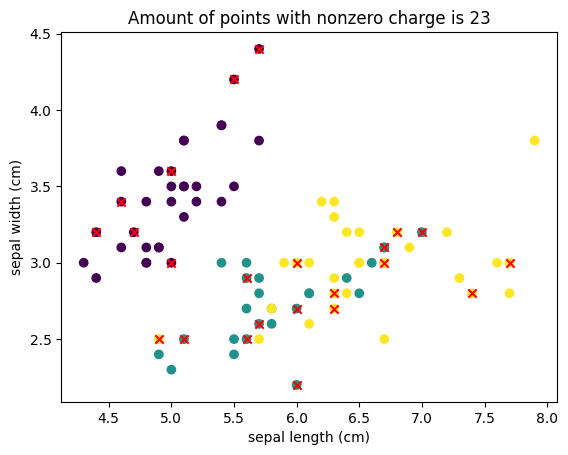

In [19]:
highlighted_features = (0, 1)
non_zero_points_indexes = potential_classifier.indexes
highlighted_features_names = (feature_names[highlighted_features[0]], feature_names[highlighted_features[1]])
plt.title(f"Amount of points with nonzero charge is {len(non_zero_points_indexes)}")
plt.scatter(train_x[:, highlighted_features[0]], train_x[:, highlighted_features[1]], c=train_y)
plt.scatter(train_x[:, highlighted_features[0]][non_zero_points_indexes],
            train_x[:, highlighted_features[1]][non_zero_points_indexes], c='r', marker='x')
plt.xlabel(highlighted_features_names[0])
plt.ylabel(highlighted_features_names[1])
print(f'Charges of nonzero points = {potential_classifier.gammas}')
print(f'Percent of nonzero points = {len(non_zero_points_indexes) / train_x.shape[0] * 100} %')

In [20]:
mistakes_indexes = potential_classifier.get_mistakes_indices(test_x, test_y)

Points where prediction is wrong (count = 1)
Percent of mistakes = 1.1111111111111112 %


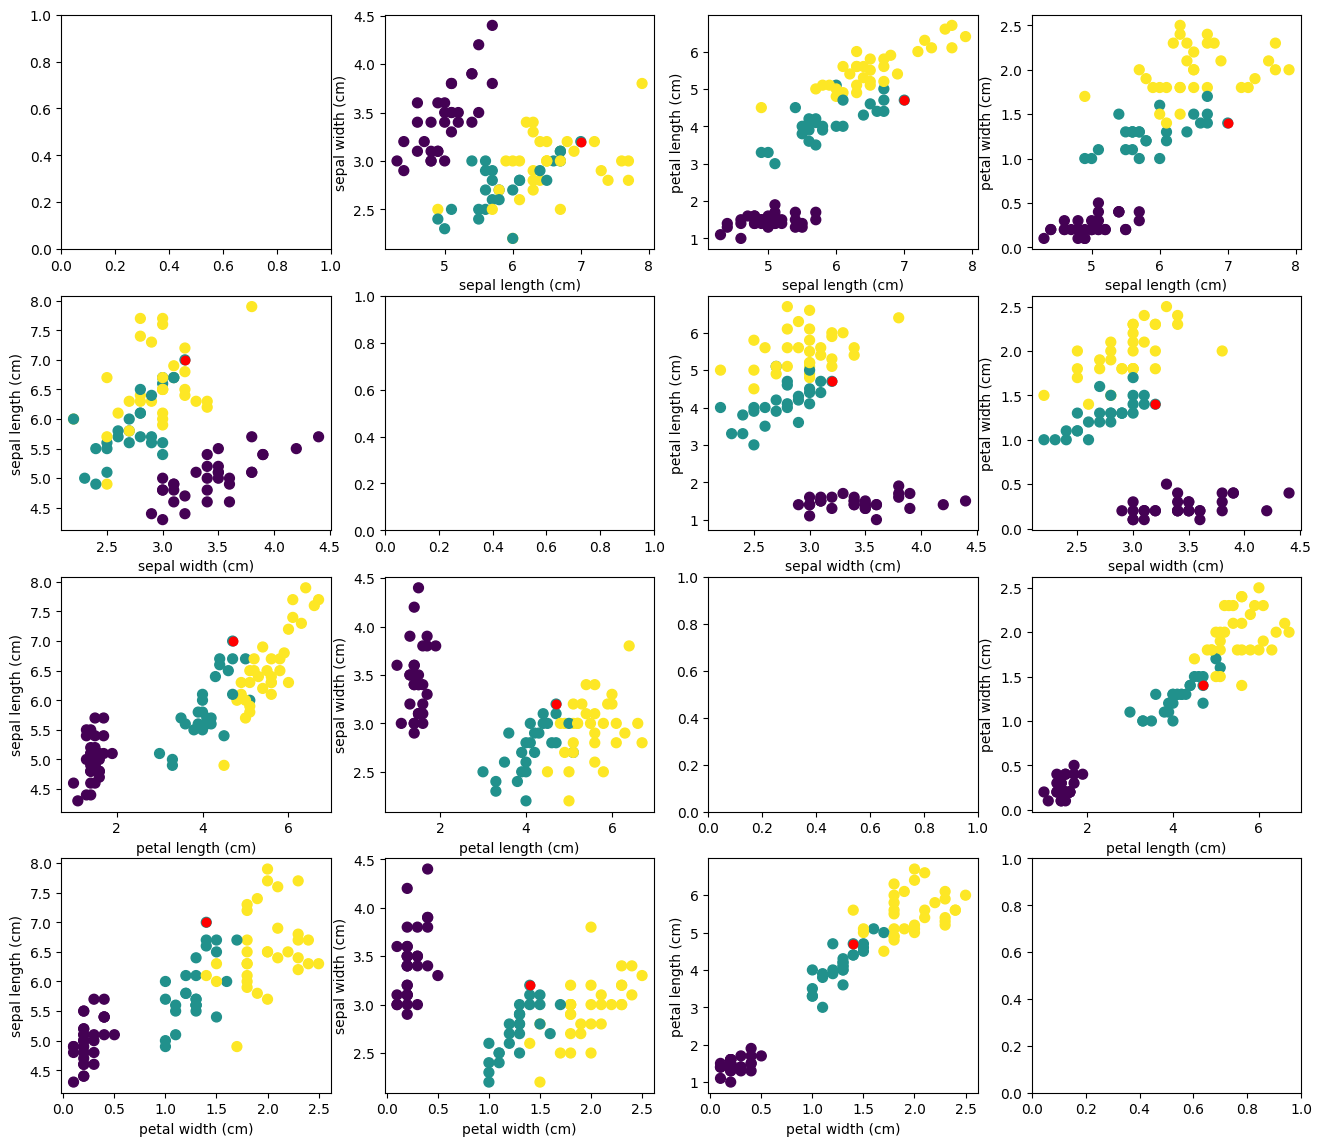

In [21]:
plt.figure(figsize=(16, 14), dpi=100)
print(f"Points where prediction is wrong (count = {len(mistakes_indexes)})")
i = 0
for x_ in range(len(feature_names)):
    for y_ in range(len(feature_names)):
        plt.subplot(4, 4, i + 1)
        i += 1
        if x_ == y_:
            continue
        else:
            plt.scatter(train_x[:, x_], train_x[:, y_], c=train_y, marker='o', s=50)
            plt.scatter(train_x[:, x_][mistakes_indexes], train_x[:, y_][mistakes_indexes], c='r', marker='.',
                        s=150)  # точки с ложными предсказанием
            plt.xlabel(feature_names[x_])
            plt.ylabel(feature_names[y_])
print(f'Percent of mistakes = {len(mistakes_indexes) / train_x.shape[0] * 100} %')

# Let's try different kernels

In [22]:
Kernels = {'Newton': NewtonianPotential, 'Quarter': QuarterPotential, 'Triangle': TrianglePotential, 'Gaussian': GaussianPotential, 'Epanechnicov': EpanechnicovPotential}

In [23]:
for kernel in Kernels:
    potential_classifier = PotentialClassifier(train_x, train_y, Kernels[kernel], 10, 2)
    potential_classifier.fit()
    print(kernel + ' accuracy is:')
    potential_classifier.show_accuracy(test_x, test_y)
    highlighted_features = (0, 1)
    non_zero_points_indexes = potential_classifier.indexes
    print(f'Charges of nonzero points = {potential_classifier.gammas}')
    print(f'Percent of nonzero points = {len(non_zero_points_indexes) / train_x.shape[0] * 100} %')
    print('')

Newton accuracy is:
Accuracy on
Test is: 0.9833333333333333;
Train is: 0.9130434782608695.
Charges of nonzero points = [1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2]
Percent of nonzero points = 25.555555555555554 %

Quarter accuracy is:
Accuracy on
Test is: 0.95;
Train is: 0.8148148148148148.
Charges of nonzero points = [1 2 2 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1]
Percent of nonzero points = 30.0 %

Triangle accuracy is:
Accuracy on
Test is: 1.0;
Train is: 0.8846153846153846.
Charges of nonzero points = [1 2 1 1 2 2 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1]
Percent of nonzero points = 28.888888888888886 %

Gaussian accuracy is:
Accuracy on
Test is: 0.95;
Train is: 0.8076923076923077.
Charges of nonzero points = [1 2 2 1 2 2 2 2 2 2 1 1 1 1 2 1 2 1 1 2 2 2 1 1 1 1]
Percent of nonzero points = 28.888888888888886 %

Epanechnicov accuracy is:
Accuracy on
Test is: 0.95;
Train is: 0.8214285714285714.
Charges of nonzero points = [1 2 2 1 2 1 2 1 2 1 1 2 1 1 1 1 2 1 1 1 1 2 2 2 1 1 

## Different amount of epochs for Newton potential

In [24]:
num_epochs = [1, 2, 3, 4, 5, 6]


for num_epoch in num_epochs:
    print(f'Epochs {num_epoch}')
    potential_classifier = PotentialClassifier(train_x, train_y, NewtonianPotential, 30, num_epoch)
    potential_classifier.fit()
    potential_classifier.show_accuracy(test_x, test_y)
    highlighted_features = (0, 1)
    non_zero_points_indexes = potential_classifier.indexes
    print(f'Charges of nonzero points = {potential_classifier.gammas}')
    print(f'Percent of nonzero points = {len(non_zero_points_indexes) / train_x.shape[0] * 100} %')
    print('')

Epochs 1
Accuracy on
Test is: 0.9666666666666667;
Train is: 0.8333333333333334.
Charges of nonzero points = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Percent of nonzero points = 20.0 %

Epochs 2
Accuracy on
Test is: 0.9833333333333333;
Train is: 0.92.
Charges of nonzero points = [1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1]
Percent of nonzero points = 27.77777777777778 %

Epochs 3
Accuracy on
Test is: 0.9333333333333333;
Train is: 0.8275862068965517.
Charges of nonzero points = [1 3 3 2 3 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 2 1 1 1 1]
Percent of nonzero points = 32.22222222222222 %

Epochs 4
Accuracy on
Test is: 0.9833333333333333;
Train is: 0.8620689655172413.
Charges of nonzero points = [1 4 4 3 4 3 4 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 4 4 3 2 1 1 1]
Percent of nonzero points = 32.22222222222222 %

Epochs 5
Accuracy on
Test is: 0.9833333333333333;
Train is: 0.896551724137931.
Charges of nonzero points = [1 5 5 4 5 4 5 2 1 2 2 1 1 1 1 1 1 2 2 2 2 2 5 5 4 2 1 1 1]
Percent of nonzero poi